# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns

import data_processing as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'data_processing' from '/Users/manonlaralandrieux/ADA2024/ada-2024-project-thedataminions/analysis/data_processing.py'>

# Configure path to data files

In [3]:
# define the path to the folder where the YouNiverse dataset is stored here

# when adding your own path, don't remove the existing path, just comment it
# in this way, everyone can quickly uncomment their own path
#dataset_root_path = "/media/andreas/Backup Plus/youniverse_dataset/"   #andreas
#dataset_root_path = "D:/youniverse/"                                    #mila
dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/"  #manon

# Preprocessing

## Loading the data

In [ ]:
# load channel data (no chunks needed, as the file is not very large)
#df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv.gz", compression="infer", sep="\t") #andreas 
df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv", compression="infer", sep="\t") # manon 

In [11]:
# load a small part of video and comment data, to try functions on them etc.
# these datasets should not be used for calculations, as they don't contain all the data

# load (first 100000 rows of) video data
#df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", compression="infer", lines=True, nrows=100000) #andreas 
df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", compression="infer", lines=True, nrows=1000000) #manon
# load (first 1000000 rows of) comment data
#df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", compression="infer", sep="\t", nrows=1000000) #andreas
df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv", compression="infer", sep="\t", nrows=1000000) #manon

In [12]:
df_channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [13]:
# definition of "readers", i.e., objects that we can iterate through 
# and always get a chunk of the dataframe in each iteration

def videos_in_chunks(chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the (unfiltered) video dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    #return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", #andreas
    return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", #manon
                        compression="infer", lines=True, chunksize=chunksize, nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                           # (remove the paranthesis above as well)

def comments_in_chunks(chunksize: int = 1000000) -> pd.io.parsers.readers.TextFileReader:
    """
    Returns a CSV reader which can be iterated through, to get chunks of the (unfiltered) comment dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the CSV reader
    """
    #return pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", #andreas
    return pd.read_csv(dataset_root_path + "youtube_comments.tsv", #manon
                       compression="infer", sep="\t", chunksize=chunksize, nrows = 10000000)  # uncomment this to only use the first 10 million comments, for testing
                                            # (remove the paranthesis above as well)

# Intro : topics distribution on YouTube
With this analysis we want to show that News&Politics is a popular category of both videos and channels to justify our choice.  

,category_cc,number_of_channels
0,Autos & Vehicles,3705
1,Comedy,3767
2,Education,7803
3,Entertainment,22951
4,Film and Animation,6875
5,Gaming,20143
6,Howto & Style,11875
7,Music,24285
8,News & Politics,2263
9,Nonprofits & Activism,969


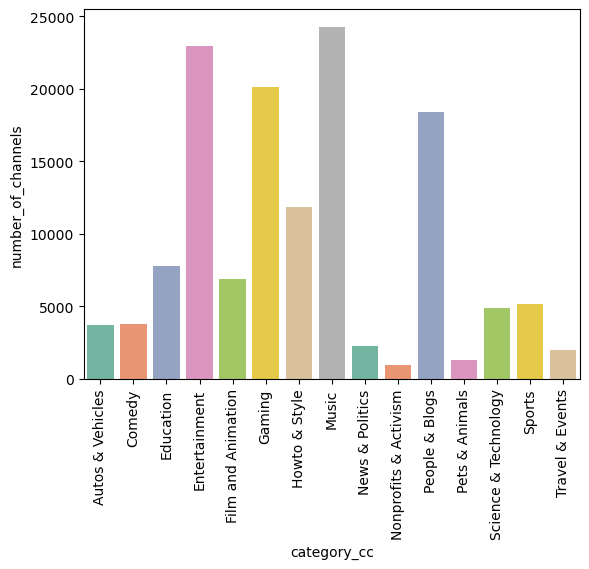

In [14]:
#distribution of categories for the channels 
category_channel= df_channels.groupby('category_cc').agg(number_of_channels=('category_cc', 'size')).reset_index()
display(category_channel)
ax = sns.barplot(x="category_cc", y="number_of_channels", data=category_channel,hue="category_cc", palette='Set2')
plt.xticks(rotation=90)
plt.show()

#instead of saying it goes in our way we could say , that it is already a small category which can lead to more isolation as people are less interested 
#and there exists less various sources thus clustering can happen more easily 

,categories,number_of_videos
0,,7
1,Autos & Vehicles,14360
2,Comedy,23249
3,Education,46987
4,Entertainment,158501
5,Film & Animation,39635
6,Gaming,199862
7,Howto & Style,52860
8,Music,129925
9,News & Politics,145768


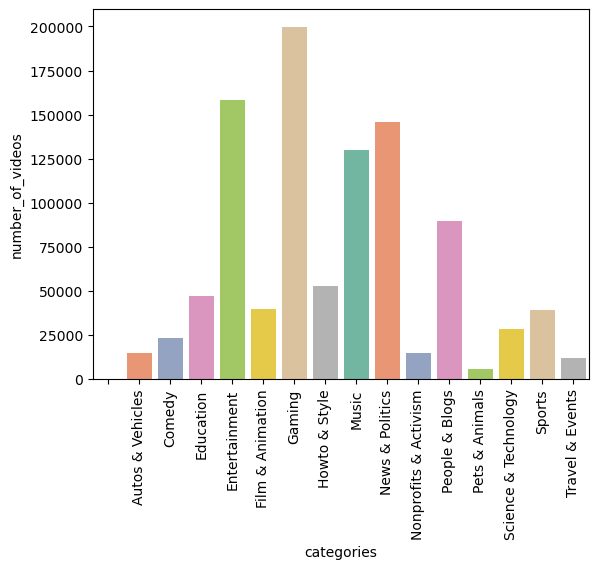

In [15]:
#distribution of categories for the videos for the first 100000 rows 

category_videos= df_videos.groupby('categories').agg(number_of_videos=('categories', 'size')).reset_index()
display(category_videos)
ax = sns.barplot(x="categories", y="number_of_videos", data=category_videos,hue="categories", palette='Set2')
plt.xticks(rotation=90)
plt.show()

#even if it isnt on the whole dataset (only on 1000000 first rows) we see here that the news & politics is a popular category for videos comapred to channels 

## Filtering for NaNs and ' ' (here in youtube_comments.tsv.gz)

Pending questions to TA (good practices): 
- is the analysis of useless data (NaN and '' rows) required for justification of their removal, or can we just go with the filtering only ?
- are we allowed to filter once the dataset is already reduced to e.g one channel, or do we have to filter in the very beginning (painful) ?

In [ ]:
#replace empty character '' with NaN and remove rows containing NaN
filtered_df = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
                                        lambda x: x.replace('Gkb1QMHrGvA', np.nan).dropna(),
                                        print_time=(1000000, 8600000000))

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
2.047 secs per chunk on average. Meaning  293.436 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
1.951 secs per chunk on average. Meaning  279.547 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
1.917 secs per chunk on average. Meaning  274.606 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
1.895 secs per chunk on average. Meaning  271.484 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
1.939 secs per chunk on average. Meaning  277.761 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
2.197 secs per chunk on average. Meaning  314.651 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

In [ ]:
#filtered df
display(filtered_df)

,author,video_id,likes,replies
1,1,CNtp0xqoods,0,0
2,1,249EEzQmVmQ,1,0
3,1,_U443T2K_Bs,0,0
4,1,rJbjhm0weYc,0,0
5,2,EpHERODJ7gM,0,0
...,...,...,...,...
9999995,664459,GC3gqIbrK7c,9,1
9999996,664459,GC3gqIbrK7c,1,0
9999997,664459,i9VRGaoFw8k,1,1
9999998,664459,-JLWZ1jz3FY,0,2


If we have to analyze NaN rows before filtering, then use this code:

In [ ]:
# get the entries of the comment dataframe which have a na value in any column
nans = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
                                        lambda x: dp.get_na_entries(x, "any", reverse=False),
                                        print_time=(1000000, 8600000000))

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
1.593 secs per chunk on average. Meaning  228.242 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
1.485 secs per chunk on average. Meaning  212.856 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
1.461 secs per chunk on average. Meaning  209.287 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
1.555 secs per chunk on average. Meaning  222.726 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
1.624 secs per chunk on average. Meaning  232.621 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
1.643 secs per chunk on average. Meaning  235.383 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

In [ ]:
# count the entries of the comment dataframe which have a na value in any column

counted_nans = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
                                                lambda x: dp.count_na_entries(x, "any", reverse=False),
                                                print_time=(1000000, 8600000000)).sum(axis=0)

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
1.338 secs per chunk on average. Meaning  191.752 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
1.330 secs per chunk on average. Meaning  190.553 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
1.283 secs per chunk on average. Meaning  183.879 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
1.271 secs per chunk on average. Meaning  182.041 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
1.266 secs per chunk on average. Meaning  181.289 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
1.265 secs per chunk on average. Meaning  181.245 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

In [ ]:
display(counted_nans)

na rows              0
total rows    10000000
dtype: int64

## Filtering the datasets to our needs

### Filtering **videos** by category 'News & Politics'

In [ ]:
# filter the video dataframe to only include videos from n&p category

df_videos_news_pol = dp.run_simple_function_on_chunks_concat(videos_in_chunks(chunksize=100000),
                                                             lambda x: x[x.categories == "News & Politics"], 
                                                             print_time=(100000, 72924794))

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
4.727 secs per chunk on average. Meaning  57.371 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
4.874 secs per chunk on average. Meaning  59.080 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
4.654 secs per chunk on average. Meaning  56.328 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
4.546 secs per chunk on average. Meaning  54.955 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
4.345 secs per chunk on average. Meaning  52.453 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
4.196 secs per chunk on average. Meaning  50.581 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
4.148 secs per chunk

In [ ]:
display(df_videos_news_pol)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
1827,News & Politics,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:42.593675,retrogamer3.com,16.0,dfa8RRkKoa4,9251,25.0,"RetroGamer3,Live Stream,politics,Trump",Retrogamer3 Political Stream,2018-08-23 00:00:00,478.0
7605,News & Politics,UCzWLsxDD373D4tY8kN-0LGQ,2019-11-05 00:42:33.012228,What are the forces at work that have created ...,0.0,_dIIEMvH86k,309,9.0,"NWO,Ebola,Ukraine,Mainstream,Media,Pyschology",Adam Curtis describes the Surkow Strategy of M...,2015-01-04 00:00:00,865.0
18005,News & Politics,UCzVBu6oqlrAix0oq9T2rBFg,2019-11-19 20:40:22.403775,Social Media:\n\nFacebook.com/thebookoflaura\n...,89.0,eWXefhNB2po,707,625.0,"michael jackson,lyrics,music video,court,child...",my thoughts on the michael jackson documentary.,2019-04-24 00:00:00,12780.0
24361,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:10.520209,👕 Order your shirts here: https://Teespring.co...,195.0,MBgzne7djFU,378,47027.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",Elizabeth Warren Gets a Big Surprise at the Ai...,2019-10-03 00:00:00,374711.0
24362,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:16.481889,👕 Order your shirts here: https://Teespring.co...,114.0,AbH3pJnFgY8,278,36384.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",No More Twitter? 😂,2019-10-02 00:00:00,245617.0
...,...,...,...,...,...,...,...,...,...,...,...,...
999870,News & Politics,UCrUkx0UAxgybbbMvWphd62Q,2019-11-10 14:27:26.687460,The Young Turks recently posted a video entitl...,2.0,Rmq0JmUbt8k,857,25.0,"American Joe,American Joe Show,The Young Turks...",Young Turks Caught Lying and Race Baiting.... ...,2018-11-17 00:00:00,273.0
999871,News & Politics,UCrUkx0UAxgybbbMvWphd62Q,2019-11-10 14:27:27.273595,Patriots I need your help growing the American...,0.0,ts__Orp310M,49,34.0,"American Joe,American Joe Show",President says he will send migrant Children B...,2018-11-15 00:00:00,353.0
999872,News & Politics,UCrUkx0UAxgybbbMvWphd62Q,2019-11-10 14:27:27.847348,Patriots I need your help growing the American...,1.0,bQ3_ZMVpiio,298,6.0,"American Joe,American Joe Show,Michael Avenatt...","Creepy Porn Lawyer, and Woman Beater Michael A...",2018-11-14 00:00:00,76.0
999873,News & Politics,UCrUkx0UAxgybbbMvWphd62Q,2019-11-10 14:27:28.400609,Patriots I need your help growing the American...,2.0,q92A939Nyj8,388,2.0,"American Joe,American Joe Show,Midterm Electio...",Midterm Fallout - How Bad is it For Trump?,2018-11-14 00:00:00,38.0


### Filtering **channels** by category News & Politics

In [ ]:
#filter channels dataset to only include n&p
df_channels_news_pol = df_channels[df_channels.category_cc == "News & Politics"]

In [ ]:
display(df_channels_news_pol)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
129,News & Politics,2006-08-26,UCttspZesZIDEwwpVIgoZtWQ,IndiaTV,15177282,139814,199.0,2.0870
133,News & Politics,2012-06-01,UCRWFSbif-RFENbBrSiez1DA,ABP NEWS,16274836,129027,207.0,2.0870
212,News & Politics,2017-03-03,UCmphdqZNmqL72WJ2uyiNw5w,ABP NEWS HINDI,10800000,51298,340.0,2.0870
268,News & Politics,2015-03-23,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,9120000,9423,438.0,2.0870
337,News & Politics,2007-06-19,UCIvaYmXn910QMdemBG3v1pQ,Zee News,9280000,102648,549.0,2.0870
...,...,...,...,...,...,...,...,...
135820,News & Politics,2010-08-07,UC5rxiCGcNunIi5zI1hMYLMg,Salman Akhtar,10400,40,962468.0,53.1435
135825,News & Politics,2013-02-01,UCLSEJQ8TWtlEkaytaa4Y7lw,WingsOfChrist,10420,61,962547.0,53.1435
135901,News & Politics,2012-10-19,UCnkG_c5cyemVVsgCDoHiXew,The American Mirror,10500,329,963417.0,53.1435
136231,News & Politics,2017-11-25,UC69lWS7UMbBQc-9yqp4nGjA,Patriotism Show,10320,46,975448.0,53.1435


In [ ]:
# check if all videos we found in news&pol are also pulished by a channel in category n&p

df_videos_news_pol[np.logical_not(df_videos_news_pol.channel_id.isin(df_channels_news_pol.channel))]



,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
1827,News & Politics,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:42.593675,retrogamer3.com,16.0,dfa8RRkKoa4,9251,25.0,"RetroGamer3,Live Stream,politics,Trump",Retrogamer3 Political Stream,2018-08-23 00:00:00,478.0
7605,News & Politics,UCzWLsxDD373D4tY8kN-0LGQ,2019-11-05 00:42:33.012228,What are the forces at work that have created ...,0.0,_dIIEMvH86k,309,9.0,"NWO,Ebola,Ukraine,Mainstream,Media,Pyschology",Adam Curtis describes the Surkow Strategy of M...,2015-01-04 00:00:00,865.0
18005,News & Politics,UCzVBu6oqlrAix0oq9T2rBFg,2019-11-19 20:40:22.403775,Social Media:\n\nFacebook.com/thebookoflaura\n...,89.0,eWXefhNB2po,707,625.0,"michael jackson,lyrics,music video,court,child...",my thoughts on the michael jackson documentary.,2019-04-24 00:00:00,12780.0
28840,News & Politics,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:38:01.617657,A young man is living a normal life with no ca...,16.0,ck6Yl8TNoWs,1257,452.0,"JoiRida,Cheatham,JoiRidaCheatham,Accepted,Detr...",Accepted - Award Winning Short Film,2013-10-13 00:00:00,27366.0
28860,News & Politics,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:38:06.565138,Short Film,1.0,tjUajxZAIZ8,422,15.0,"Joi.Rida,Cheatham,joiridacheatham,dread,loc,up...",JoiRida Twin Visit (Introducing Jive Viper),2010-03-04 00:00:00,987.0
...,...,...,...,...,...,...,...,...,...,...,...,...
970869,News & Politics,UCrXcatz6wlNHjuqgf-tglOA,2019-11-07 00:55:48.241832,"As promised, our Wet Head Challenge using the ...",3.0,lIuK9DGtOx8,321,141.0,"challenge,wet,head,gross,wet head challenge,we...",Gross Smoothie Wet Head Challenge 😕,2016-08-23 00:00:00,8941.0
991815,News & Politics,UCrVnMcE3GIyg2rM4gH34YWg,2019-11-10 10:02:03.075065,More Travel News...\nhttp://www.petergreenberg...,0.0,aSWbywb7SBE,423,1.0,"2008,Travel Inspiration,clinton,Presidential,P...",2008 Presidential Candidates Travel Scorecard,2008-01-25 00:00:00,588.0
998347,News & Politics,UCrV-WEtbXrRIkgWgbXLAvcQ,2019-10-31 15:06:30.119011,© 2012 WMG Webisode by Mutemath from The Blue...,3.0,H8-Al6B_J1g,106,17.0,"mutemath,wbr,INDMUSIC,warner bros records",Mutemath - What Happens Before The Show [Webis...,2006-11-04 00:00:00,3136.0
998349,News & Politics,UCrV-WEtbXrRIkgWgbXLAvcQ,2019-10-31 15:06:31.498209,© 2012 WMG Webisode by Mutemath from Park Wes...,2.0,wYI6dWaEHjk,56,8.0,"INDMUSIC,wbr,mutemath,warner bros records",Mutemath - Built for Destruction [Webisode],2006-11-04 00:00:00,1881.0


**We see that indeed, not all videos in the news and politics category belong to a channel in this category!**
A google search shows that apparently, you don't have to have the same category for all videos, but you set a "default" channel category which will be used for videos if you don't change it manually. Also, you can probably change the default category after a while if you want.

This is the reason why most of the news&pol videos are uploaded by a news&pol channe, but not all.

In the paper about the dataset, the authors say that the channel category is actually the "most frequent category", so I guess the video categories are the most relevant, as they are the true categories.

We could try to verify this, if we want to.

### Filtering the N&P videos by a list of channels

In [ ]:
# form the filtered N&P videos dataframe, keep those posted by channels manually selected (here CNN, Fox News, BBC News and MSNBC)

df_videos_news_pol_manually_selected = df_videos_news_pol[df_videos_news_pol.channel_id.isin(["UCupvZG-5ko_eiXAupbDfxWw",  # CNN
                                                                                              "UCXIJgqnII2ZOINSWNOGFThA",  # Fox News
                                                                                              "UC16niRr50-MSBwiO3YDb3RA",  # BBC News
                                                                                              "UCaXkIU1QidjPwiAYu6GcHjg",  # MSNBC
                                                                                            ])]

In [ ]:
df_videos_news_pol_manually_selected

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count


### Doing our own ranking of N&P channels (not necessary)

In [ ]:
# sort the previously filtered n&p channels by subscriber count according to channel crawler
#df_channels_news_pol_sort_subscribers = df_channels_news_pol.sort_values(by="subscribers_cc", ascending=False)

In [ ]:
#display(df_channels_news_pol_sort_subscribers)

### Filtering **videos** in a specific channel
Note: This function doesn't have to be done on the whole video dataset, as it is done here, since we have previously filtered N&P videos of specific channels.
Therefore, we would also not need chunks here.

Todo: simplify the function like this:

df_videos_news_pol_manually_selected.loc[df_videos_news_pol_manually_selected.channel_id == <channel id of the desired channel>]


In [ ]:
# filter the video dataset to get only videos from a specific channel (here: random channel)

videos_from_channel_test = dp.run_simple_function_on_chunks_concat(
    videos_in_chunks(chunksize=100000),
    lambda x: x.loc[x.channel_id == "UCzWrhkg9eK5I8Bm3HfV-unA"],
    print_time=(100000, 72924794))

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
4.383 secs per chunk on average. Meaning  53.197 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
4.894 secs per chunk on average. Meaning  59.320 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
5.154 secs per chunk on average. Meaning  62.384 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
5.209 secs per chunk on average. Meaning  62.960 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
4.883 secs per chunk on average. Meaning  58.936 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
4.698 secs per chunk on average. Meaning  56.631 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
4.577 secs per chunk

### Filtering **comments** in a specific channel

This second function probably needs to look like this, as we haven't preprocessed the comment data yet, so it is still too big to be considered all at once, so we need the chunks.

In [ ]:
# get comments on videos from a specific channel using the ids from filtered video dataset

comments_from_channel_test = dp.run_simple_function_on_chunks_concat(
    comments_in_chunks(chunksize=1000000), 
    lambda df: df[df.video_id.isin(videos_from_channel_test.display_id)],
    print_time=(1000000, 8600000000))

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
1.515 secs per chunk on average. Meaning  217.056 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
1.874 secs per chunk on average. Meaning  268.605 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
1.919 secs per chunk on average. Meaning  274.950 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
1.906 secs per chunk on average. Meaning  273.121 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
1.851 secs per chunk on average. Meaning  265.222 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
1.948 secs per chunk on average. Meaning  279.084 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

In [ ]:
display(comments_from_channel_test.head())

,author,video_id,likes,replies
6868268,453667,3vQK78eUg2A,2,1
7094579,468696,SWZG-ba1qDk,15,18
8912192,594074,hn2zYwqSINY,0,1


### Plots 
1. Using the previous functions, plot the tot nb of comments and/or subscribers in the selected channels (all on same plot).

2. For each channel, plot the distribution of comments for all the users.

## Selecting the cluster of users in a specific channel 

(flexible function where you give the threshold of x comments)


In [ ]:
#returns df with users_id and total number of comments made in a specific channel
def get_metadata_commenters(comment_channelX,x):
    metadata_commenters = comment_channelX.groupby('author').agg(number_of_comments=('author', 'size')).reset_index()
    metadata_commenters['number_of_videos']= comment_channelX.groupby('author')['video_id'].nunique().values
    
    #keep users that wrote more than x comments 
    metadata_commenters=metadata_commenters[metadata_commenters['number_of_comments']>=x]
    return metadata_commenters

#test with threshold x=0
metadata_commenters= get_metadata_commenters(comments_from_channel_test,0)
display(metadata_commenters)

,author,number_of_comments,number_of_videos
0,453667,1,1
1,468696,1,1
2,594074,1,1


### Plots
1. Venn diagram with clusters of the channels and underline overlaps

# Deeper analysis and statistics
Todo: 
create dataset of all comments which are under a video in the news and politics category

use this dataset to get the list of videos under which each of the users we found (above) have made a comment

for each pair of users, calculate "number of videos in common (under which both have commented) / min number of videos both users have commented on"
(example: mila commented on 10 videos, andreas on 100 videos, they have 8 videos they both commented on, so the value we calculate is 8/10 = 0.8)
